In [3]:
!pip install -q kagglehub


[notice] A new release of pip is available: 24.1.2 -> 25.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import kagglehub

path = kagglehub.dataset_download("muratkokludataset/pistachio-image-dataset")

print("Path to dataset files:", path)

100%|█████████████████████████████████████████████████████████████████████████████| 26.7M/26.7M [00:03<00:00, 8.41MB/s]

Extracting files...


Path to dataset files: C:\Users\anshu\.cache\kagglehub\datasets\muratkokludataset\pistachio-image-dataset\versions\1


In [2]:
import os
import shutil

destination = "pistachhio"
os.makedirs(destination, exist_ok=True)

shutil.move(path, destination)
print("Dataset moved to:", destination)

In [3]:
os.listdir('pistachhio/Pistachio_Image_Dataset/Pistachio_Image_Dataset')

['Kirmizi_Pistachio', 'Pistachio_Image_Dataset_Request.txt', 'Siirt_Pistachio']

In [4]:
import os
import pandas as pd

dataset_root = 'pistachhio/Pistachio_Image_Dataset/Pistachio_Image_Dataset'

items = os.listdir(dataset_root)

data = []

for item in items:
    folder_path = os.path.join(dataset_root, item)
    if os.path.isdir(folder_path):
        label = item.split("_")[0].lower()
        
        for file_name in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file_name)
            data.append({
                'filepath': file_path,
                'label': label
            })

df = pd.DataFrame(data)

In [6]:
df.to_csv('pistachio_dataset')

In [8]:
# df = pd.read_csv('pistachio_dataset')

In [9]:
df.head()

,filepath,label
0,pistachhio/Pistachio_Image_Dataset/Pistachio_I...,kirmizi
1,pistachhio/Pistachio_Image_Dataset/Pistachio_I...,kirmizi
2,pistachhio/Pistachio_Image_Dataset/Pistachio_I...,kirmizi
3,pistachhio/Pistachio_Image_Dataset/Pistachio_I...,kirmizi
4,pistachhio/Pistachio_Image_Dataset/Pistachio_I...,kirmizi


In [10]:
df['filepath'][0]

'pistachhio/Pistachio_Image_Dataset/Pistachio_Image_Dataset\\Kirmizi_Pistachio\\kirmizi (1).jpg'

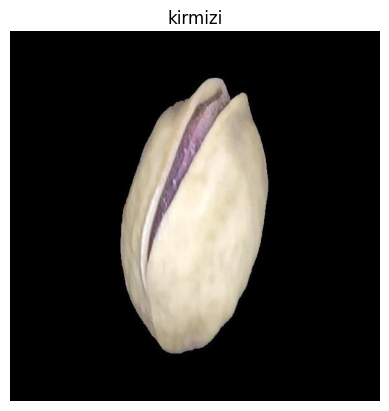

In [11]:
from PIL import Image
import matplotlib.pyplot as plt

def view_image(n):
    img = Image.open(df['filepath'][n])
    plt.imshow(img)
    plt.axis('off')
    plt.title(df['label'][n])
    plt.show()

    
view_image(1)

In [12]:
from sklearn.model_selection import train_test_split

train_df, dummy_df = train_test_split(df,  test_size= 0.2, shuffle= True, random_state= 21)

valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 21)

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import inspect

print(inspect.signature(ImageDataGenerator))

(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)


In [14]:
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepath', y_col= 'label', target_size= img_size, class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 1718 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.
Found 215 validated image filenames belonging to 2 classes.


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, GlobalAveragePooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

In [16]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

inputs = tf.keras.Input(shape=img_shape)

base_model = keras.applications.EfficientNetB3(include_top=False, weights="imagenet", 
input_tensor=inputs)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
inspect.signature(model.fit)

<Signature (x=None, y=None, batch_size=None, epochs=1, verbose='auto', callbacks=None, validation_split=0.0, validation_data=None, shuffle=True, class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None, validation_steps=None, validation_batch_size=None, validation_freq=1)>

In [18]:
import tensorflow as tf
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1, verbose=1),
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    tensorboard_callback
]

history1 = model.fit(
    train_gen, 
    epochs=5, 
    verbose=1, 
    validation_data=valid_gen, 
    shuffle=False,
    callbacks=callbacks
)

Epoch 1/5


C:\Users\anshu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 686ms/step - accuracy: 0.7748 - loss: 15.0098

C:\Users\anshu\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 6.12358, saving model to best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 104s 836ms/step - accuracy: 0.7751 - loss: 14.9852 - val_accuracy: 0.8279 - val_loss: 6.1236
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 669ms/step - accuracy: 0.8541 - loss: 6.8838
Epoch 2: val_loss improved from 6.12358 to 5.06865, saving model to best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 786ms/step - accuracy: 0.8541 - loss: 6.8777 - val_accuracy: 0.6326 - val_loss: 5.0686
Epoch 3/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 667ms/step - accuracy: 0.8355 - loss: 4.9780
Epoch 3: val_loss improved from 5.06865 to 4.22039, saving model to best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 785ms/step - accuracy: 0.8354 - loss: 4.9758 - val_accuracy: 0.6651 - val_loss: 4.2204
Epoch 4/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.8130 - loss: 4.0679
Epoch 4: val_loss improved from 4.22039 to 3.47953, saving model to best_model.keras
108/108 ━━━━━━━━━━━━━━━━━━━━ 91s 841ms/s

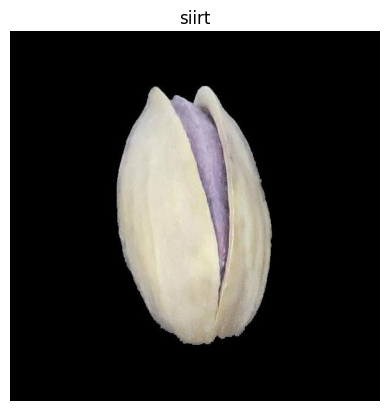

In [19]:
view_image(2000)

In [20]:
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.efficientnet import preprocess_input

img_size = (224, 224)

img_path = df['filepath'][2044]
img = load_img(img_path, target_size=img_size)

img_array = img_to_array(img)

img_batch = np.expand_dims(img_array, axis=0)

img_batch = preprocess_input(img_batch)

predictions = model.predict(img_batch)

predicted_index = np.argmax(predictions, axis=1)[0]

class_indices = train_gen.class_indices
inv_class_indices = {v: k for k, v in class_indices.items()}

predicted_label = inv_class_indices[predicted_index]

print("Predicted label:", predicted_label)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted label: siirt


In [21]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

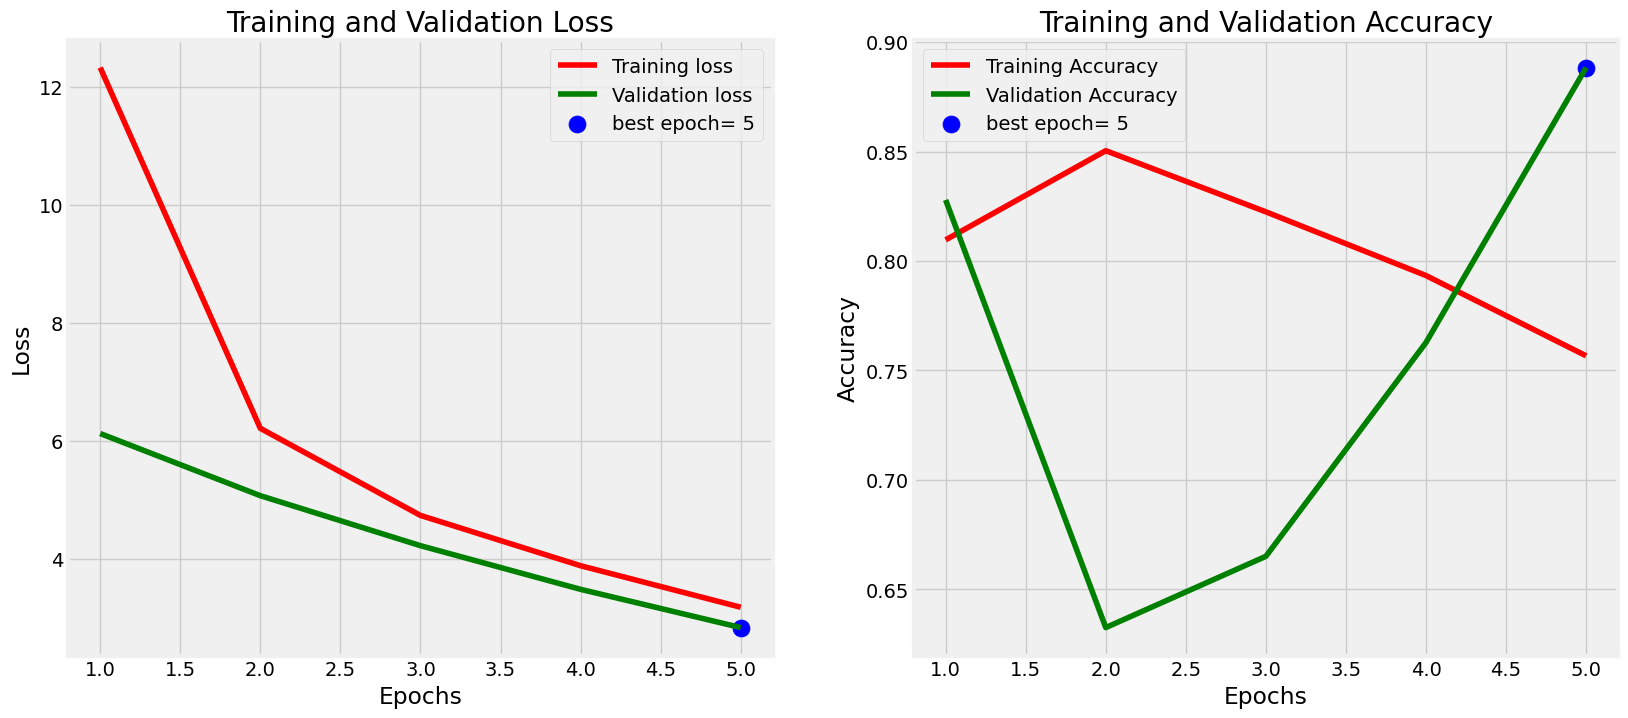

In [22]:
plot_training(history1)

In [23]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

inputs = tf.keras.Input(shape=img_shape)

base_model = keras.applications.ResNet50(include_top=False, weights="imagenet", 
input_tensor=inputs)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
history2 = model.fit(train_gen, epochs=5, verbose=1, validation_data=valid_gen, shuffle=False, callbacks = callbacks)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 699ms/step - accuracy: 0.7654 - loss: 14.8736
Epoch 1: val_loss did not improve from 2.83047
108/108 ━━━━━━━━━━━━━━━━━━━━ 94s 827ms/step - accuracy: 0.7659 - loss: 14.8474 - val_accuracy: 0.8512 - val_loss: 6.9084
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 674ms/step - accuracy: 0.9037 - loss: 6.6650
Epoch 2: val_loss did not improve from 2.83047
108/108 ━━━━━━━━━━━━━━━━━━━━ 85s 792ms/step - accuracy: 0.9035 - loss: 6.6603 - val_accuracy: 0.7395 - val_loss: 5.2470
Epoch 2: early stopping


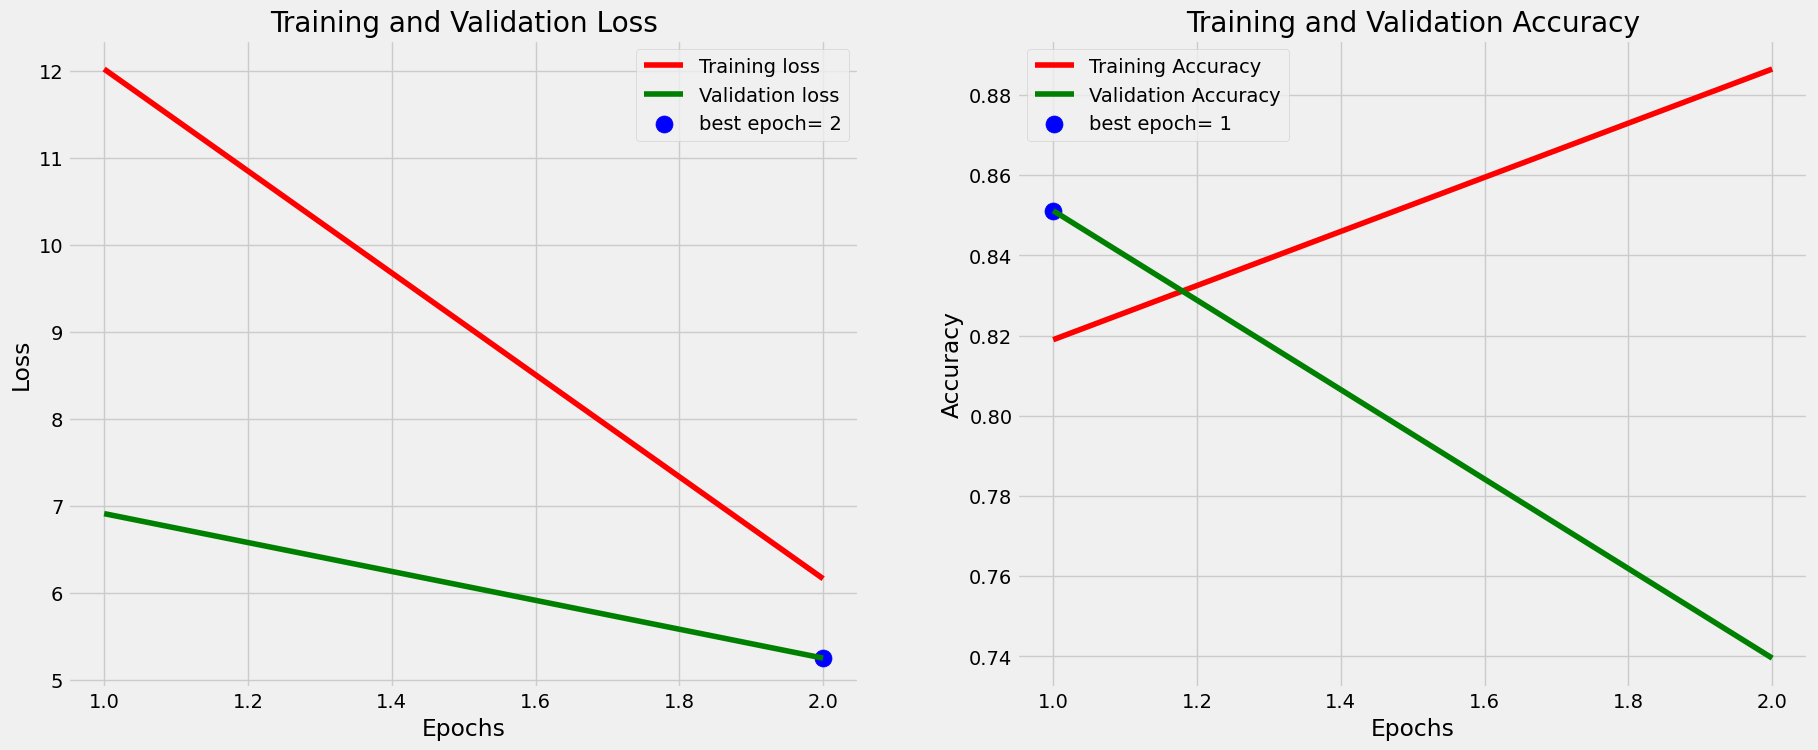

In [25]:
plot_training(history2)

In [26]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

inputs = tf.keras.Input(shape=img_shape)

base_model = tf.keras.applications.VGG16(include_top=False, weights="imagenet", input_tensor=inputs)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization(momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=0.45, seed=123)(x)
outputs = Dense(class_count, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
history3 = model.fit(train_gen, epochs=5, verbose=1, validation_data=valid_gen, shuffle=False, callbacks = callbacks)

Epoch 1/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7745 - loss: 13.8665
Epoch 1: val_loss did not improve from 2.83047
108/108 ━━━━━━━━━━━━━━━━━━━━ 198s 2s/step - accuracy: 0.7750 - loss: 13.8475 - val_accuracy: 0.8930 - val_loss: 8.3301
Epoch 2/5
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8969 - loss: 6.9050
Epoch 2: val_loss did not improve from 2.83047
108/108 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.8967 - loss: 6.8959 - val_accuracy: 0.8837 - val_loss: 4.2625
Epoch 2: early stopping


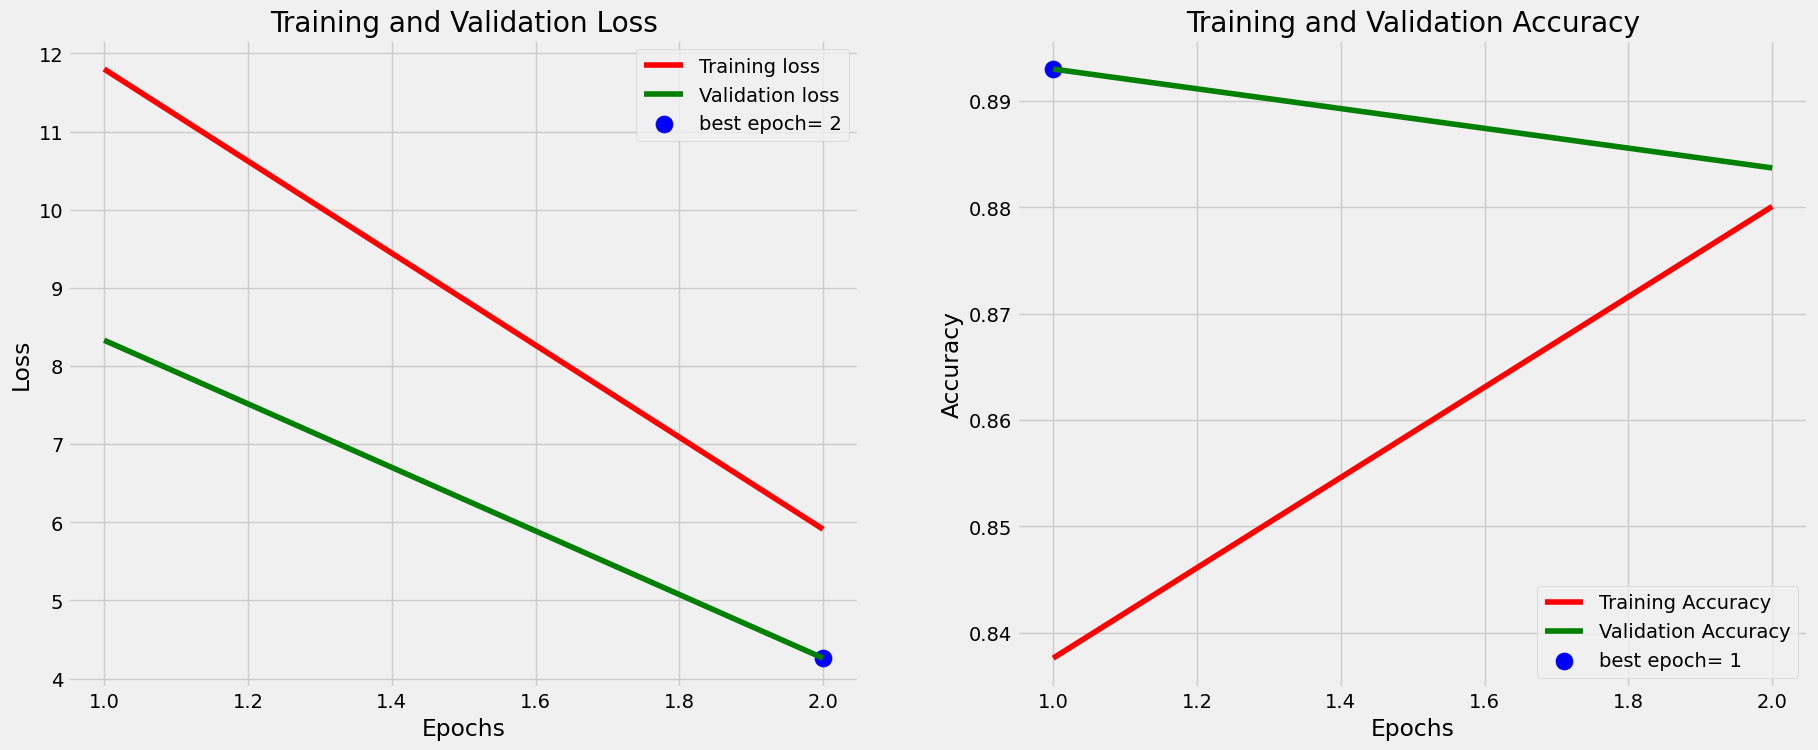

In [28]:
plot_training(history3)